# Cell/particle Counting and scoring stained objects

This notebook demonstrates how to process plates associated to the paper ['Integration of biological data by kernels on graph nodes allows prediction of new genes involved in mitotic chromosome condensation.'](http://dx.doi.org/10.1091/mbc.E13-04-0221) using [CellProfiler](http://cellprofiler.org/).
We use the example pipeline [Cell/particle counting, and scoring the percentage of stained objects](http://cellprofiler.org/examples/#PercentPositive). This pipeline is for two-channel images.

### Import Packages

In [1]:
# %tb

# Import Cell Profiler Dependencies
import cellprofiler
import cellprofiler_core.preferences as cpprefs
import cellprofiler.modules as cpm
import cellprofiler_core.pipeline as cpp
cpprefs.set_headless()

# Inject Image module used to inject OMERO image planes into Cell Profiler Pipeline
from cellprofiler_core.modules.injectimage import InjectImage

# Import OMERO Python BlitzGateway
import omero
from omero.gateway import BlitzGateway

# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import pandas
import warnings

# Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt

### Set Cell Output Directory

In [2]:
new_output_directory = os.path.normcase(tempfile.mkdtemp())
cpprefs.set_default_output_directory(new_output_directory)

### Connect to IDR

In [3]:
conn = BlitzGateway(host='ws://idr.openmicroscopy.org/omero-ws', username='public', passwd='public', secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### Fetch from IDR the Plate that contains the Images to be analysed

In [4]:
plate_id = 422
plate = conn.getObject("Plate", plate_id)
print('Plate Name: ', plate.getName())

Plate Name:  plate1_1_013


In [5]:
# Load pipeline and inspect modules
from os.path import expanduser
home = expanduser("~")
pipeline = cpp.Pipeline()
pipeline.load(home+"/notebooks/pipelines/ExamplePercentPositive.cppipe")

# Remove first 4 modules: Images, Metadata, NamesAndTypes, Groups...
# (replaced by InjectImage module below)
for i in range(4):
    print('Remove module: ', pipeline.modules()[0].module_name)
    pipeline.remove_module(1)

print('Pipeline modules:')
for module in pipeline.modules():
    print(module.module_num, module.module_name)

Remove module:  Images
Remove module:  Metadata
Remove module:  NamesAndTypes
Remove module:  Groups
Pipeline modules:
1 IdentifyPrimaryObjects
2 IdentifyPrimaryObjects
3 RelateObjects
4 FilterObjects
5 MeasureObjectIntensity
6 OverlayOutlines
7 DisplayDataOnImage
8 ClassifyObjects
9 CalculateMath
10 ExportToSpreadsheet


### Run Cell Profiler Pipeline on the plate

In [6]:
warnings.filterwarnings('ignore')

Nuclei = pandas.DataFrame()
files = list()

# create list from generator
wells = list(plate.listChildren())
# use the first 5 wells only
wells = wells[0:5]
well_count = len(wells)

for count, well in enumerate(wells):
    print('Well: %s/%s' % (count + 1, well_count), 'row:', well.row, 'column:', well.column)
    # Load a single Image per Well
    image = well.getImage(0)
    pixels = image.getPrimaryPixels()
    size_c = image.getSizeC()

    # For each Image in OMERO, we copy pipeline and inject image modules
    pipeline_copy = pipeline.copy()

    # Inject image for each Channel (pipeline only handles 2 channels)
    for c in range(0, size_c):

        plane = pixels.getPlane(0, c, 0)
        image_name = image.getName()

        # Name of the channel expected in the pipeline
        if c == 0:
            image_name = 'OrigBlue'
        if c == 1:
            image_name = 'OrigGreen'

        inject_image_module = InjectImage(image_name, plane)
        inject_image_module.set_module_num(1)
        pipeline_copy.add_module(inject_image_module)

    m = pipeline_copy.run()

    # Results obtained as CSV from Cell Profiler
    path = new_output_directory + '/Nuclei.csv'
    f = pandas.read_csv(path, index_col=None, header=0)
    f['Image'] = image.getId()
    f['Well'] = well.getId()
    f['Cell_Count'] = len(f.index)
    files.append(f)

Nuclei = pandas.concat(files, ignore_index=True)

Well: 1/5 row: 4 column: 10
Well: 2/5 row: 7 column: 5
Well: 3/5 row: 2 column: 0
Well: 4/5 row: 1 column: 1
Well: 5/5 row: 6 column: 4


### Calculate statistics

In [7]:
Nuclei.describe()

,ImageNumber,ObjectNumber,Children_PH3PosNuclei_Count,Children_PH3_Count,Classify_PH3Neg,Classify_PH3Pos,Intensity_IntegratedIntensityEdge_OrigBlue,Intensity_IntegratedIntensityEdge_OrigGreen,Intensity_IntegratedIntensity_OrigBlue,Intensity_IntegratedIntensity_OrigGreen,...,Location_MaxIntensity_X_OrigBlue,Location_MaxIntensity_X_OrigGreen,Location_MaxIntensity_Y_OrigBlue,Location_MaxIntensity_Y_OrigGreen,Location_MaxIntensity_Z_OrigBlue,Location_MaxIntensity_Z_OrigGreen,Number_Object_Number,Image,Well,Cell_Count
count,183.0,183.000000,183.0,183.0,183.0,183.0,183.000000,183.000000,183.000000,183.000000,...,183.000000,183.000000,183.000000,183.000000,183.0,183.0,183.000000,183.000000,183.000000,183.000000
mean,1.0,20.939891,0.0,0.0,1.0,0.0,1.014310,2.150691,29.646527,33.606067,...,641.207650,640.595628,504.426230,505.092896,0.0,0.0,20.939891,179696.027322,67065.027322,40.879781
std,0.0,13.378336,0.0,0.0,0.0,0.0,0.166875,0.656799,9.692252,13.056507,...,379.397542,378.464118,290.259857,290.867133,0.0,0.0,13.378336,1.495163,1.495163,10.821569
min,1.0,1.000000,0.0,0.0,1.0,0.0,0.195392,0.188174,0.925505,0.549798,...,25.000000,40.000000,23.000000,26.000000,0.0,0.0,1.000000,179694.000000,67063.000000,16.000000
25%,1.0,10.000000,0.0,0.0,1.0,0.0,0.931441,1.723491,24.218746,25.092157,...,328.500000,327.000000,229.500000,223.500000,0.0,0.0,10.000000,179695.000000,67064.000000,34.000000
50%,1.0,19.000000,0.0,0.0,1.0,0.0,1.015808,2.227451,28.140276,35.143267,...,622.000000,626.000000,549.000000,554.000000,0.0,0.0,19.000000,179696.000000,67065.000000,47.000000
75%,1.0,31.000000,0.0,0.0,1.0,0.0,1.110864,2.666171,34.749775,41.995651,...,945.000000,952.000000,753.500000,762.000000,0.0,0.0,31.000000,179698.000000,67067.000000,52.000000
max,1.0,52.000000,0.0,0.0,1.0,0.0,1.597894,3.525551,70.744503,66.551629,...,1320.000000,1326.000000,1004.000000,992.000000,0.0,0.0,52.000000,179698.000000,67067.000000,52.000000


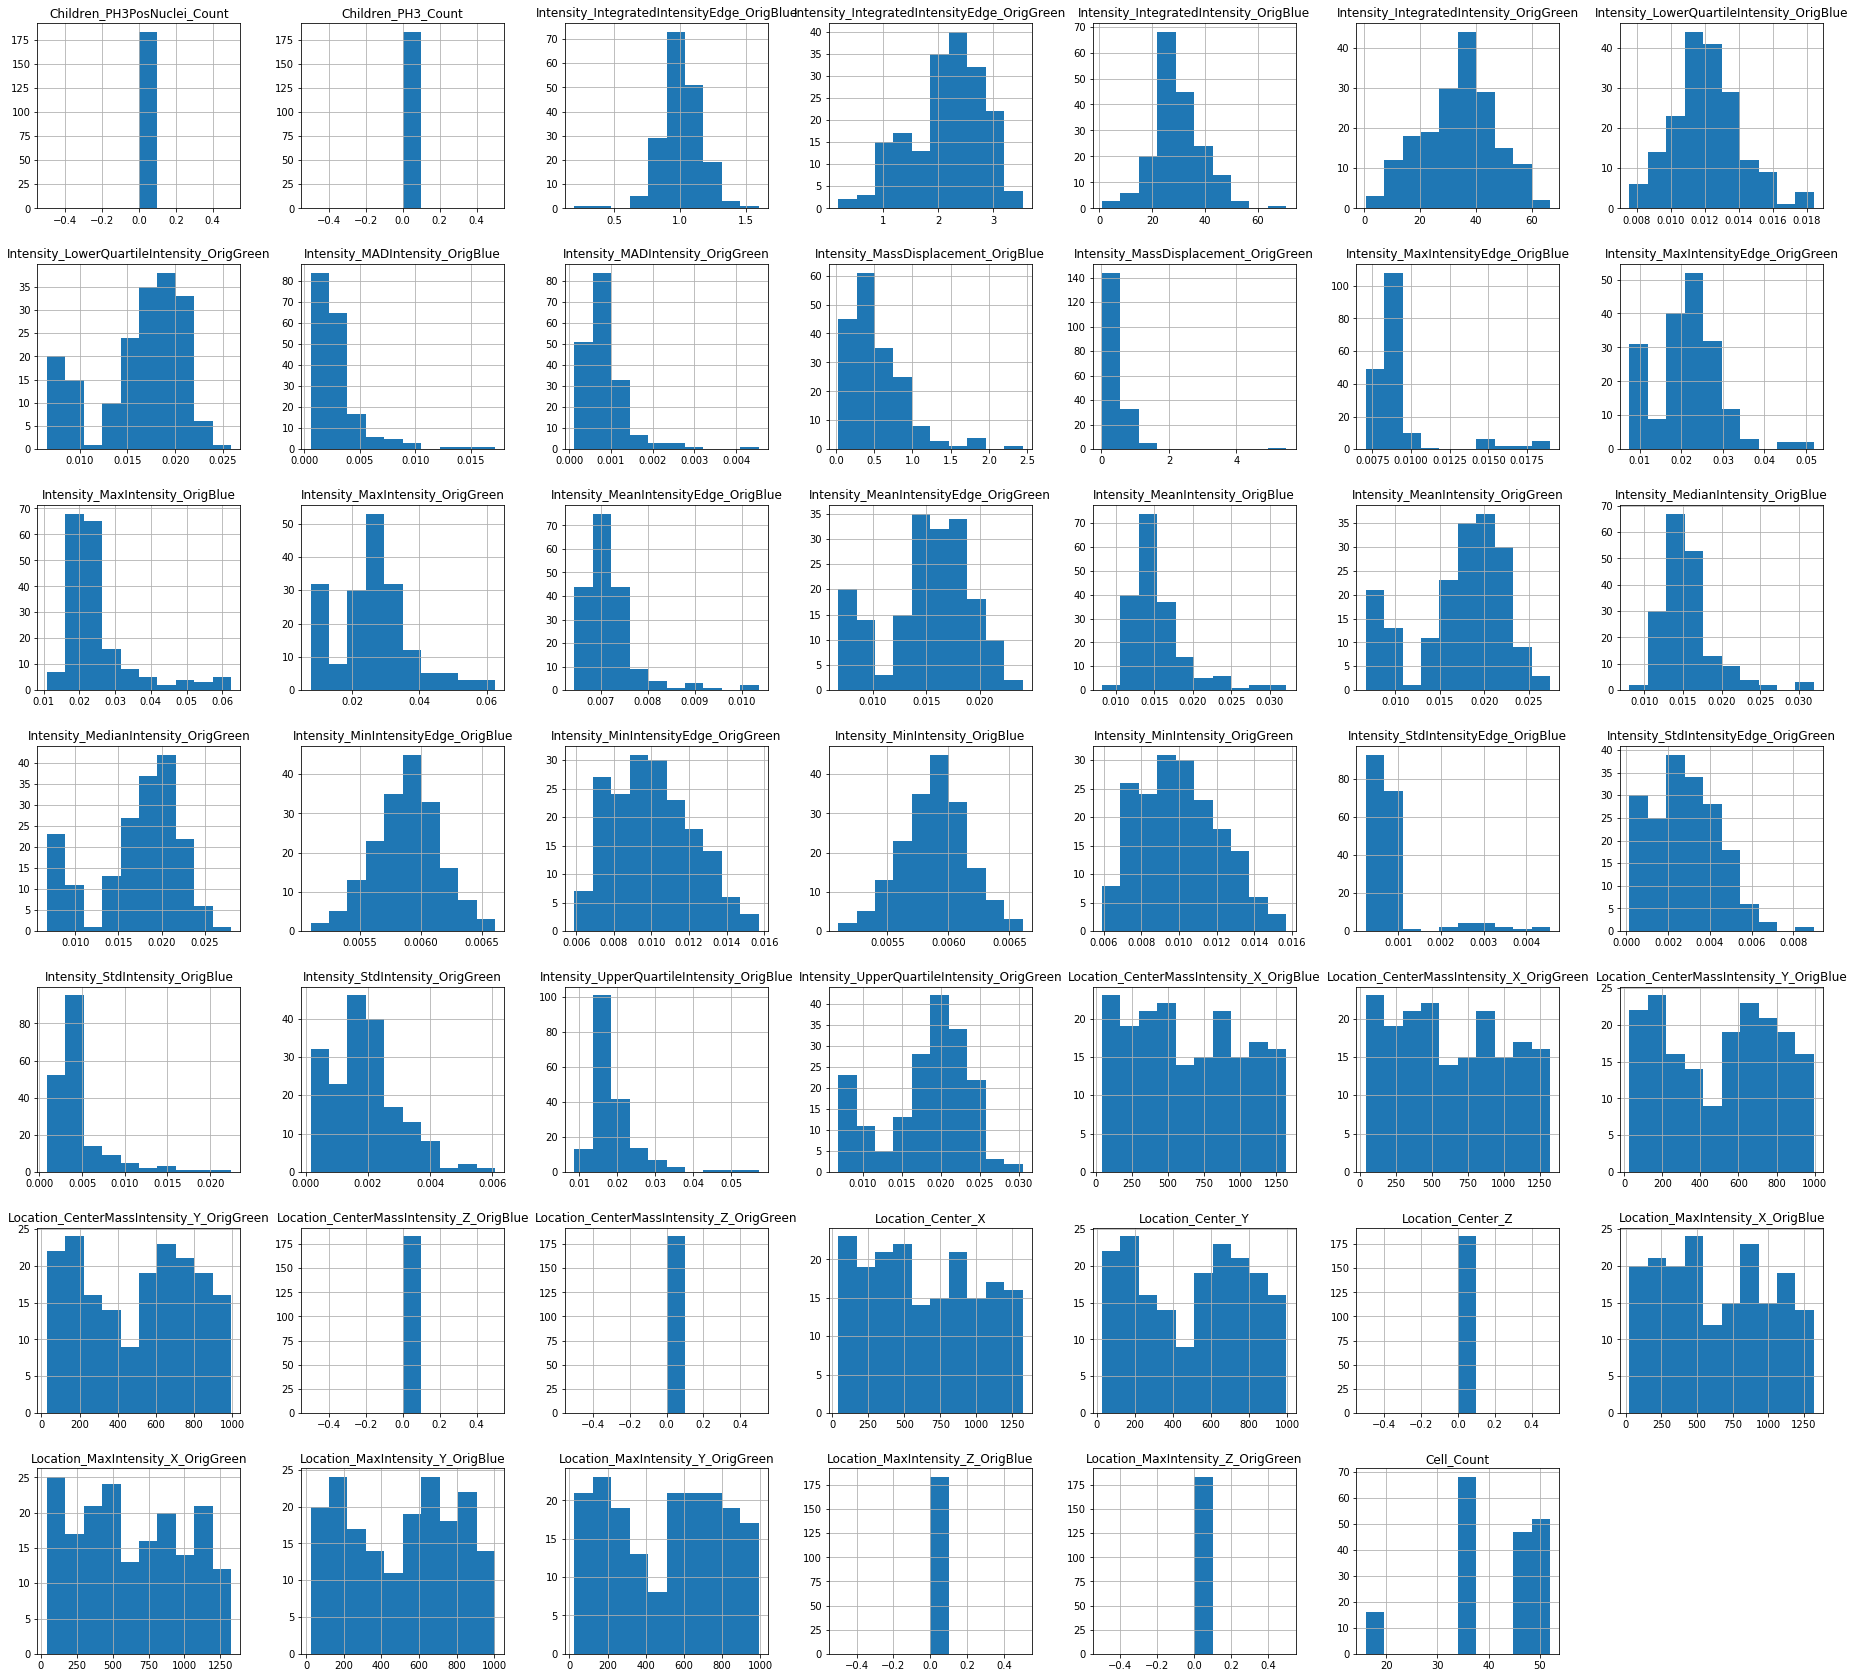

In [8]:
matplotlib.rcParams['figure.figsize'] = (32.0, 30.0)
# Drop few columns
df = Nuclei.drop(['Image', 'ImageNumber', 'Well', 'ObjectNumber', 'Number_Object_Number', 'Classify_PH3Neg', 'Classify_PH3Pos'], axis=1)
df.hist();

### Close the connection to the server

In [ ]:
conn.close()